In [8]:
from matplotlib import pyplot
import datetime, matplotlib, numpy, pandas, random, scipy, seaborn

pyplot.style.use('fivethirtyeight')
matplotlib.rcParams['figure.figsize'] = (15, 9)

I made a New Year's resolution that I would include uncertainty estimates in every plot I draw in 2018. So far it's holding up resonably well. But what a deep rabbit hole it is! I started with some basic knowledge of bootstrapping and confidence intervals, but I've since then had to pick up a whole arsenal of tricks involving Monte Carlo methods and inverse Hessians. I'm not going to show you _how_ deep the rabbit hole, but I think there's some of it that's really neat. Either way, it's been a great way to deepen my knowledge about ~~rabbits~~ statistics, so I thought I'd share some of these tools.

I don't believe in learning things without a concrete example, so let's generate some data. We're going to generate a fake time series where the dates range from 2017-07-01 to 2018-07-31 and we have observations for each date indicating maybe an air pressure or something. I don't know, use your imagination :)

In [17]:
def generate_time_series(k=700, m=1000, n=50,
                         start_date=datetime.date(2017, 7, 1)):
    xs = numpy.linspace(0, 1, n, endpoint=False)
    ys = [k*x + m + random.gauss(0, 500) for x in xs]
    ts = [start_date + datetime.timedelta(x)*365 for x in xs]
    x_scale = numpy.linspace(-1, 2, 500) # for plotting
    t_scale = [start_date + datetime.timedelta(x)*365 for x in x_scale]
    return xs, ys, ts, x_scale, t_scale

xs, ys, ts, x_scale, t_scale = generate_time_series()

Before we get started with anything, we need graphics. Let's plot to see what's going on!

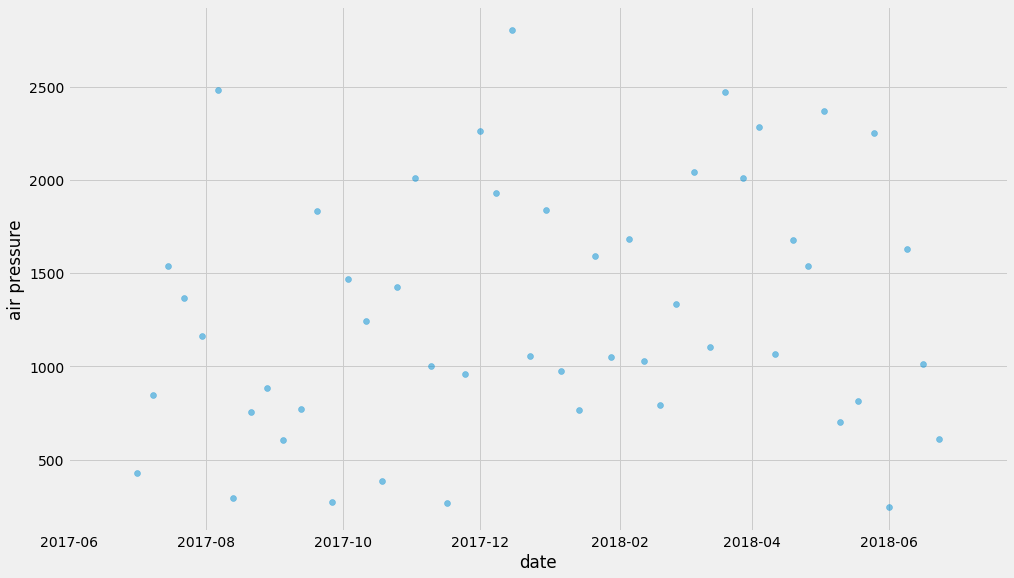

In [18]:
pyplot.scatter(ts, ys, alpha=0.5)
pyplot.xlabel('date')
pyplot.ylabel('air pressure')
pyplot.show()

First of all, let's not fit any fancy models. We're just going to break it up into a few buckets and compute the mean within each bucket. But let's first pause and talk about uncertainty.

# Distribution of the data vs uncertainty

This makes me sometimes feel dumb but I keep confusing what "uncertainty" means and I think it's important to be hyper clear because we're going to do all of them. Let's say we're trying to understand quantity sold as a function of cost. There's multiple different things we can estimate the distribution for:

1. The data itself. Given a certain time frame $(t, t')$, what's the distribution of air pressure during that time interval?
2. The uncertainty of some parameter, like the parameter $k$ in a linear relationship $y = kt + m$.
3. The uncertainty of predicted quantities. So if we predict that for a date $t$ (possibly in the future), we're going to have air pressure $y$, we want to know the uncertainty of the quantity $y$.

Hope that makes sense! Let's start with the most basic model – just break things up in buckets. I recommend the excellent Seaborn package if we just want to get some basic idea of distributions and uncertainty estimates. Seaborn usually operates on dataframes so we're going to use that for the next few plots:

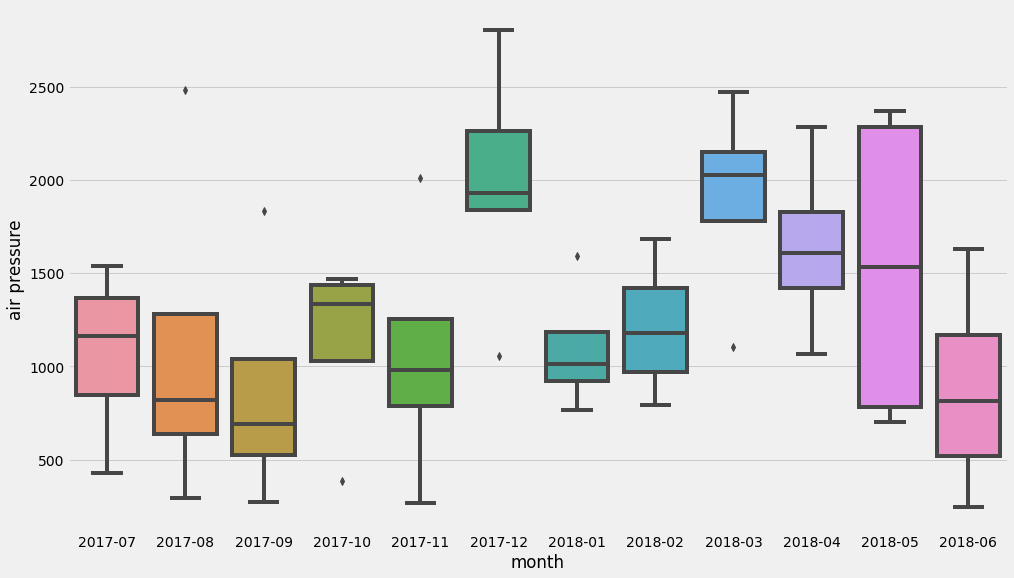

In [19]:
d = pandas.DataFrame({'x': xs, 't': ts, 'air pressure': ys})
d['month'] = d['t'].apply(lambda t: t.strftime('%Y-%m'))
seaborn.boxplot(data=d, x='month', y='air pressure')

These last charts show the _distribution_ of the dataset. Let's now try to figure out the uncertainty of a very common estimator: the _mean_!

## Computing the uncertainty of the mean – normal distributions

OK! enough fooling around with Seaborn. If we actually wanted to compute the uncertainty estimates ourselves, how would we do that?

Under some mild assumptions (I'm going to get back to this in a sec and scrutinize it), we can compute the confidence intervals as:

$\bar{x} \pm 1.96\sigma / \sqrt{n}$

Where $\bar{x}$ is the mean and $\sigma$ is the standard deviation, a.k.a. the square root of the variance. I don't think this formula is super important to remember, but I think it's somewhat useful to remember that the _size of the confidence interval is inversely related to the square root of the number of samples._ For instance, this is useful when you're running an A/B test – if you want to detect a 1% difference then you need something on the order of $0.01^{-2} = 10,000$ samples. (This is a rule of thumb, don't use it for your medical device software).

By the way – what's the 1.96 number from? It's directly related to the size of the uncertainty estimate. With $\pm 1.96$ you will cover about 95% of the probability distribution.

Let's compute this ourselves and split it (rather than relying on Seaborn):

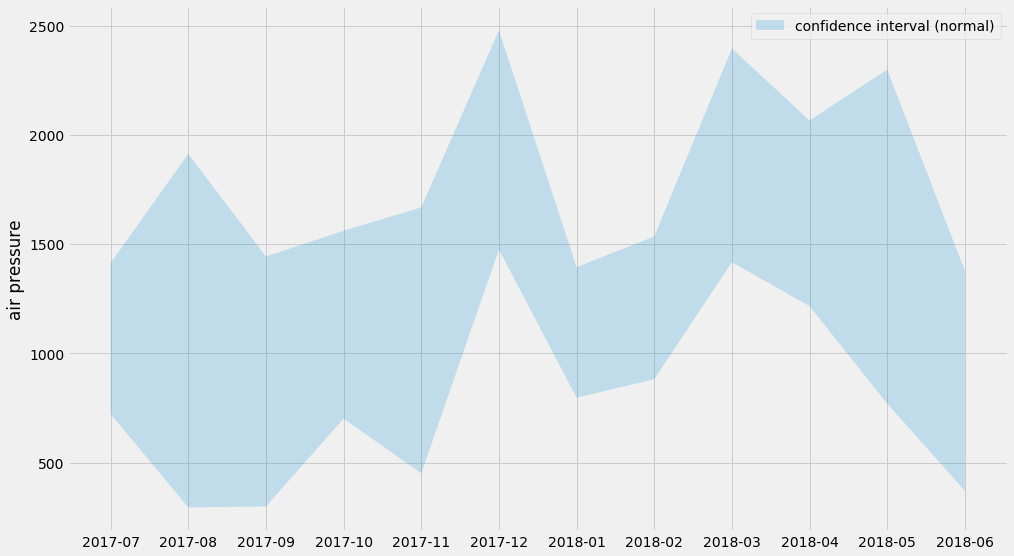

In [20]:
def plot_confidence_interval(observations_by_group):
    groups = list(sorted(observations_by_group.keys()))
    lo_bound = []
    hi_bound = []
    for group in groups:
        series = observations_by_group[group]
        mu, std, n = numpy.mean(series), numpy.std(series), len(series)
        lo_bound.append(mu - 1.96*std*n**-0.5)
        hi_bound.append(mu + 1.96*std*n**-0.5)
    pyplot.fill_between(groups, lo_bound, hi_bound, alpha=0.2,
                        label='confidence interval (normal)')

observations_by_month = {}
for month, y in zip(d['month'], d['air pressure']):
    observations_by_month.setdefault(month, []).append(y)
plot_confidence_interval(observations_by_month)
pyplot.ylabel('air pressure')
pyplot.legend()

I mentioned earlier that the formula for confidence interval only applies under some mild assumptions. What are those? It's the assumption of _normality_. For a large number of observations, this is nothing to worry about, and this is due to the [central limit theorem](https://en.wikipedia.org/wiki/Central_limit_theorem).

# Confidence intervals when all outcomes are 0 or 1

I lied a bit before when I said that I don't believe in learning things without a concrete example. In fact, I don't believe in learning things without at least _two_ examples. So I'm going to briefly switch to another dataset because it illustrates some other points that I think are useful.

The code to generate this data set isn't terribly important, but basically let's say we're running an A/B test that has some impact and that we're trying to understand the impact on conversion rate _by state_. Conversion is always 0 or 1.

In [21]:
STATES = ['CA', 'NY', 'FL', 'TX', 'PA', 'IL', 'OH']
GROUPS = ['test', 'control']

def generate_binary_categorical(states=STATES, groups=GROUPS, k=400,
                                zs=[0, 0.2], z_std=0.1, b=-3, b_std=1):
    output = {}
    e_obs_per_state = numpy.random.exponential(k, size=len(states))
    state_biases = numpy.random.normal(b, b_std, size=len(states))
    for group, z in zip(groups, zs):
        noise = numpy.random.normal(z, z_std, size=len(states))
        ps = 1 / (1 + numpy.exp(-(state_biases + noise)))
        ns = numpy.random.poisson(e_obs_per_state)
        ks = numpy.random.binomial(ns, ps)
        output[group] = (ns, ks)
    return output

Let's plot the conversion rate per state to see what's going on!

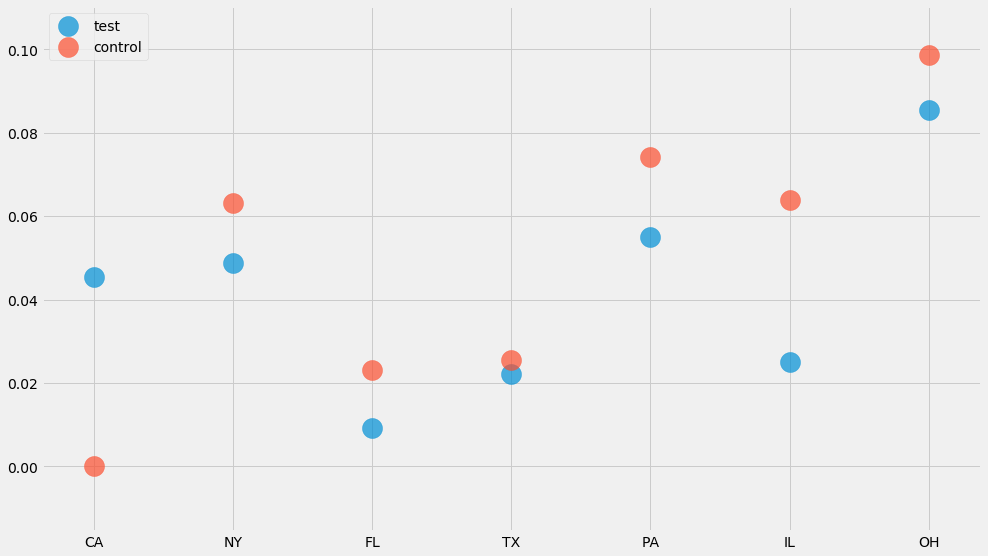

In [22]:
data = generate_binary_categorical()

for group, (ns, ks) in data.items():
    pyplot.scatter(STATES, ks/ns, label=group, alpha=0.7, s=400)

pyplot.legend()

How do we compute confidence intervals for these numbers? We could of course use the method I just covered further up where we compute the mean and the standard deviations. But in this case there's a trick we can use!

Since all outcomes are 0 or 1, and drawn with the same (unknown) probability, we know that the number of ones and zeros follows a [binomial distribution](https://en.wikipedia.org/wiki/Binomial_distribution). This means that the confidence interval of a "$k$ out of $n$" scenario is a [Beta distribution](https://en.wikipedia.org/wiki/Beta_distribution).

I've personally benefitted from memorizing the formula for the confidence interval and think I probably use it more than the previous (Normal based) one. In particular all you need to remember is

In [23]:
n, k = 100, 3
scipy.stats.beta.ppf([0.025, 0.975], k, n-k)

array([0.00629335, 0.07107612])

This will compute a 95% confidence interval if you plug in values for $n$ and $k$. In this case we see that if we have 100 website visitors and 3 of them purchased the product, then the 90% uncertainty estimate is 0.8%-6.2%. Let's try this for our dataset:

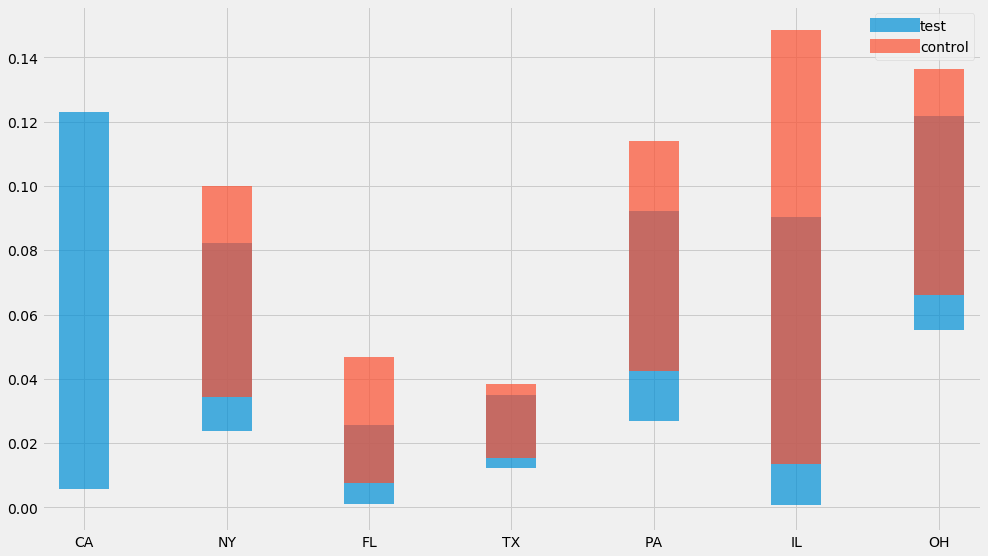

In [24]:
for group, (ns, ks) in data.items():
    lo = scipy.stats.beta.ppf(0.025, ks, ns-ks)
    hi = scipy.stats.beta.ppf(0.975, ks, ns-ks)
    mean = ks/ns
    pyplot.errorbar(STATES, y=mean, yerr=[mean-lo, hi-mean],
                    label=group, alpha=0.7, linewidth=0, elinewidth=50)

pyplot.legend()


## Bootstrapping

Another approach that can be useful is bootstrapping. It allows you do compute the same statistics without memorizing any formulas. The idea is to compute the mean, but do it for $n$ _bootstraps_, where each bootstrap is a random sample (with replacement) from our observations. For every bootstrap, we compute a mean, and then we take the mean in the 97.5th and the 2.5th percentile as the confidence interval:

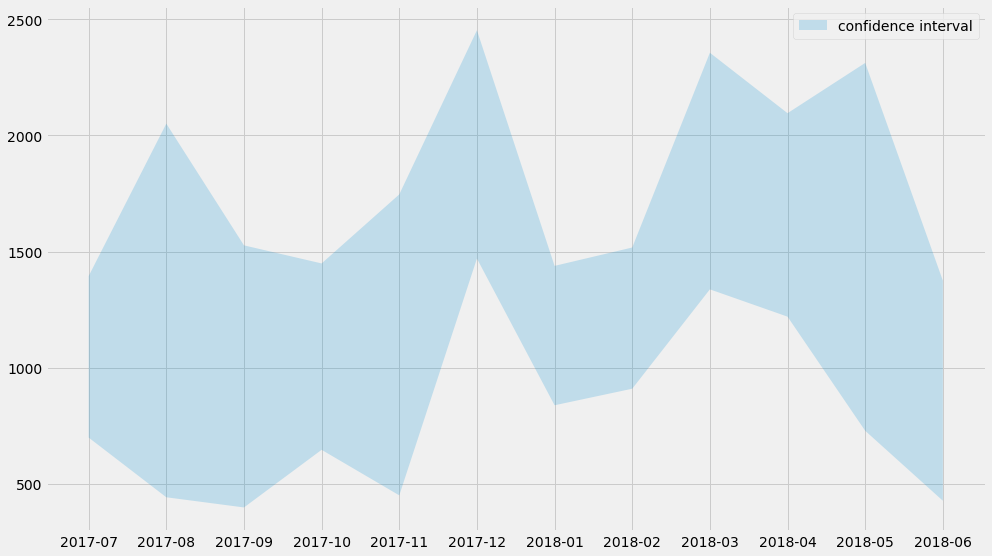

In [25]:
lo_bound = []
hi_bound = []
months = sorted(observations_by_month.keys())
for month in months:
    series = observations_by_month[month]
    bootstrapped_means = []
    for i in range(1000):
        # sample with replacement
        bootstrap = [random.choice(series) for _ in series]
        bootstrapped_means.append(numpy.mean(bootstrap))
    lo_bound.append(numpy.percentile(bootstrapped_means, 2.5))
    hi_bound.append(numpy.percentile(bootstrapped_means, 97.5))
pyplot.clf()
pyplot.fill_between(months, lo_bound, hi_bound, alpha=0.2,
                    label='confidence interval')
pyplot.legend()

Miraculously, this charts look very similar to the one before! Just kidding – that was sort of expected :)

Bootstrapping is nice because it lets you dodge any questions about what probability distribution the data is generated from. It's basically plug and play, and works on almost everything, thought it can be a bit slow.

Be aware though that there's a *danger zone* of bootstrapping. My understanding is that bootstrapping will _converge_ towards the correct estimates as the number of samples goes to infinity, but if you're working with small samples, you can get really wonky results. I generally never trust bootstrapping for anything less than say 50 samples, and neither should you.

As a side note, Seaborn's `barplot` actually plots confidence intervals (using bootstrapping):

/Users/erikbern/uncertainty/env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


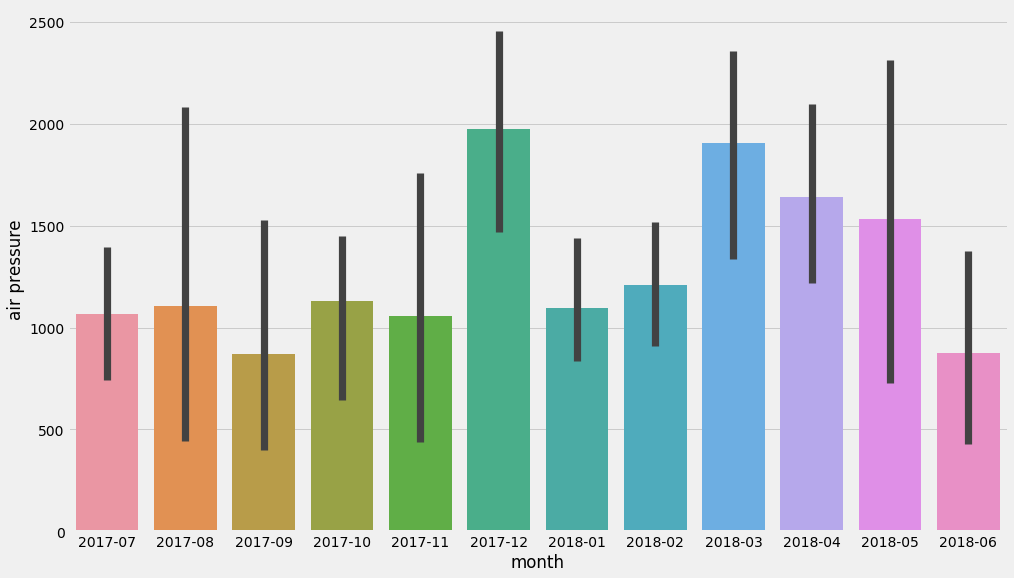

In [26]:
seaborn.barplot(data=d, x='month', y='air pressure')

# Regression

Let's crank it up a notch. We're going to fit a straight line to this cloud of points.

There's some smart ways you can implement linear regression so that it's extremely fast, but we're not going to use those methods because they don't generalize very well.

I'm going to do it in what I think of as the most general possible way. We're going to define a _model_ (in this case a straight line), a _loss function_ (squared deviations from this straight line) and then optimize it using a general-purpose solver (scipy.optimize.minimize).

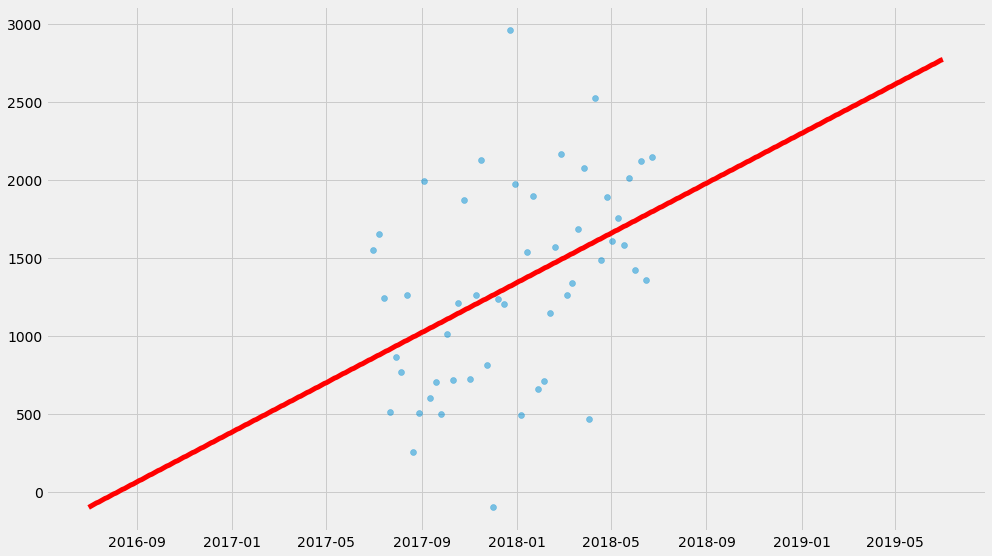

In [27]:
xs, ys, ts, x_scale, t_scale = generate_time_series()

def model(xs, k, m):
    return k * xs + m

def l2_loss(tup, xs, ys):
    k, m = tup
    delta = model(xs, k, m) - ys
    return numpy.dot(delta, delta)

k_hat, m_hat = scipy.optimize.minimize(l2_loss, (0, 0), args=(xs, ys)).x
pyplot.scatter(ts, ys, alpha=0.5)
pyplot.plot(t_scale, model(x_scale, k_hat, m_hat), color='red', linewidth=5)

## Linear regression with uncertainty, using maximum likelihood

We just fit $k$ and $m$ but there's no uncertainty estimates here. There's several things we could estimate uncertainties for, but let's start with the _uncertainty of the predicted values_.

We can do that by fitting a normal distribution around the line _at the same time_ as we're fitting $k$ and $m$. I'm going to do this using [Maximum Likelihood](https://en.wikipedia.org/wiki/Maximum_likelihood_estimation). If you're not familiar with this method, don't be scared! If there's _any_ method in statistics that I've found as easily accessible (it's basic probability theory) and useful, it's this method.

In fact, minimizing squared loss (which we just did, in the previous snippet) is actually a special case of maximum likelihood! Minimizing the squared loss is the same thing as _maximizing the logarithm of the probability of all the data._ This is usually called the "log likelihood".

So we already have an expression to minimize the squared loss. If we make the variance an unknown variable $\sigma^2$ we can fit that at the same time! The quantity we're going to try to minimize now turns into

$ \frac{n}{2}\log{2\pi\sigma^2} + \frac{1}{2\sigma^2}\sum \left(y_i - \hat{y_i}\right)^2 $

Where $\hat{y_i} = kx_i + m$ are the predicted values by our model. Let's try to fit that!

No handles with labels found to put in legend.


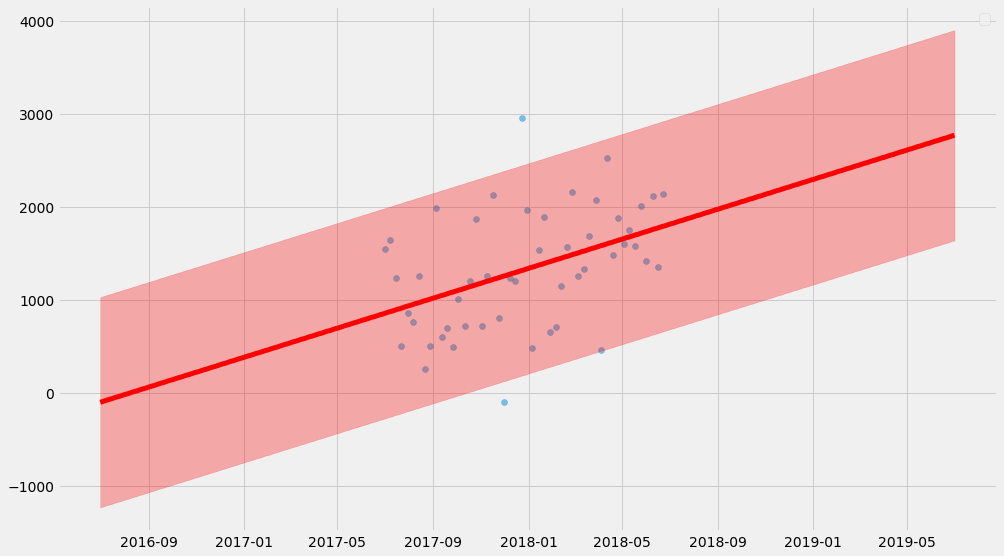

In [28]:
import scipy.optimize

def neg_log_likelihood(tup, xs, ys):
    # Since sigma > 0, we use use log(sigma) as the parameter instead.
    # That way we have an unconstrained problem.
    k, m, log_sigma = tup
    sigma = numpy.exp(log_sigma)
    delta = model(xs, k, m) - ys
    return len(xs)/2*numpy.log(2*numpy.pi*sigma**2) + \
        numpy.dot(delta, delta) / (2*sigma**2)

k_hat, m_hat, log_sigma_hat = scipy.optimize.minimize(
    neg_log_likelihood, (0, 0, 0), args=(xs, ys)
).x
sigma_hat = numpy.exp(log_sigma_hat)
pyplot.scatter(ts, ys, alpha=0.5)
pyplot.plot(t_scale, model(x_scale, k_hat, m_hat), color='red', linewidth=5)
pyplot.fill_between(
    t_scale,
    model(x_scale, k_hat, m_hat) - 1.96*sigma_hat,
    model(x_scale, k_hat, m_hat) + 1.96*sigma_hat,
    color='red', alpha=0.3)
pyplot.legend()

The uncertainty estimate here isn't actually 💯 because it doesn't take into account the uncertainty of $k$, $m$, and $\sigma$ in itself. It's a decent approximation, but to get it right we need to do those things at the same time. So let's do it.

# Bootstrapping, again

So let's take it to the next level and try to estimate the uncertainty estimate of $k$ and $m$ _and_ $\sigma$! I think this will show how bootstrapping is basically cookie cutter – you can plug it into almost anything in order to estimate uncertainties.

For every bootstrap estimate, I'm going to draw a line. We can also take all those lines and compute a confidence interval:

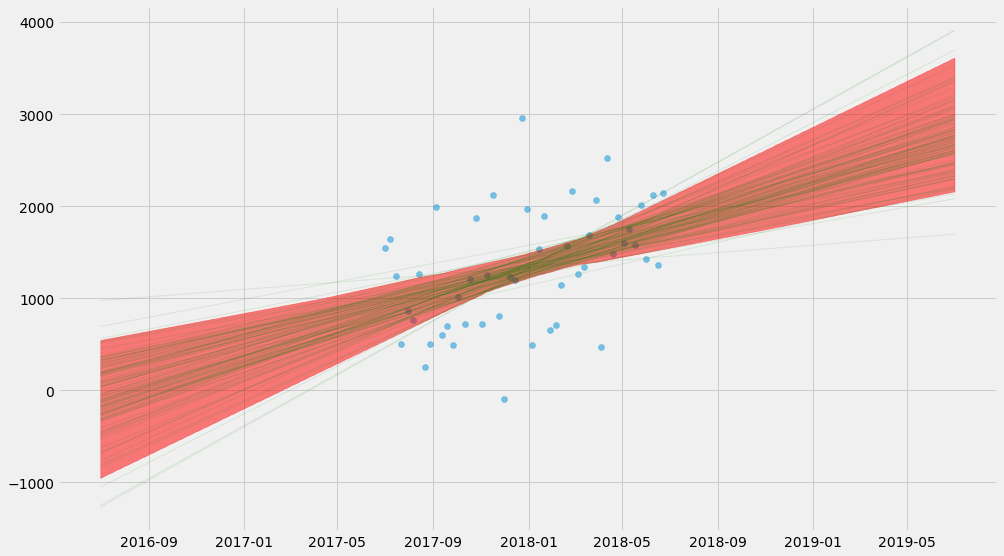

In [29]:
pyplot.scatter(ts, ys, alpha=0.5)
xys = list(zip(xs, ys))
curves = []
for i in range(100):
    # sample with replacement
    bootstrap = [random.choice(xys) for _ in xys]
    xs_bootstrap = numpy.array([x for x, y in bootstrap])
    ys_bootstrap = numpy.array([y for x, y in bootstrap])
    k_hat, m_hat = scipy.optimize.minimize(
        l2_loss, (0, 0), args=(xs_bootstrap, ys_bootstrap)
    ).x
    curves.append(model(x_scale, k_hat, m_hat))

# Plot individual lines
for curve in curves:
    pyplot.plot(t_scale, curve, alpha=0.1, linewidth=1, color='green')

# Plot 95% confidence interval
lo, hi = numpy.percentile(curves, (2.5, 97.5), axis=0)
pyplot.fill_between(t_scale, lo, hi, color='red', alpha=0.5)


Whoa, what's going on here? This uncertainty is _very_ different from the earlier plot. This seems confusing until you realize that they show two very different things:

* The first plot finds _one_ solution of $k$ and $m$ and shows the uncertainty of the _predictions._ So, if you're asked what's the range of air pressure in the next month, you can get it from the chart.
* The second plot finds _many_ solutions of $k$ and $m$, and shows the uncertainty of $kx + m$. So this answers a different question – what's the trend of air pressure over time and what's the uncertainty _of the trend_.

It turns out we can combine the two approaches and make it even more complicated by fitting drawing bootstrap samples and fitting $k$, $m$, and $\sigma$ at the same time. Then for each of those estimates, we can predict new values $y$. Let's do it 😎.

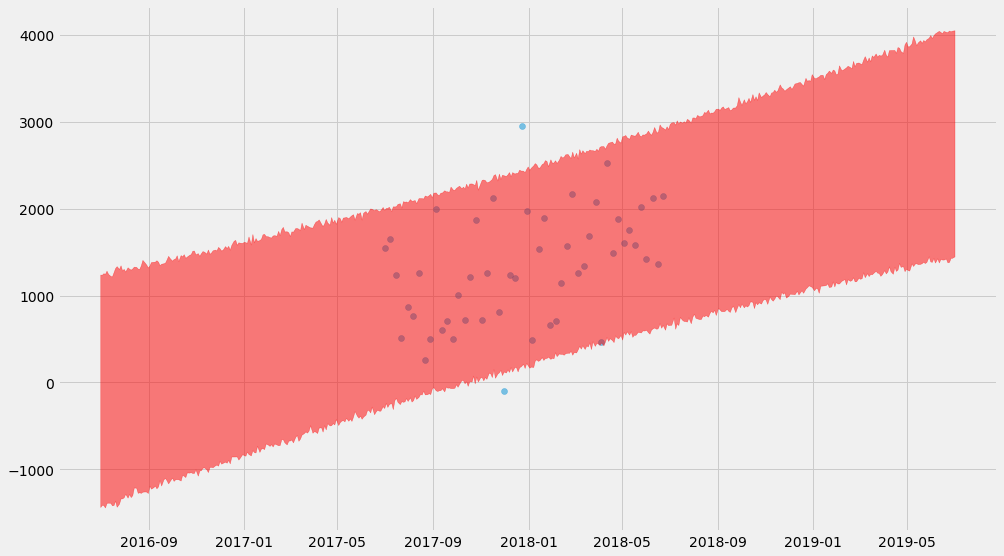

In [30]:
pyplot.scatter(ts, ys, alpha=0.5)
xys = list(zip(xs, ys))
curves = []
for i in range(4000):
    # sample with replacement
    bootstrap = [random.choice(xys) for _ in xys]
    xs_bootstrap = numpy.array([x for x, y in bootstrap])
    ys_bootstrap = numpy.array([y for x, y in bootstrap])
    k_hat, m_hat, log_sigma_hat = scipy.optimize.minimize(
        neg_log_likelihood, (0, 0, 0), args=(xs_bootstrap, ys_bootstrap)
    ).x
    curves.append(
        model(x_scale, k_hat, m_hat) +
        # Note what's going on here: we're _adding_ the random term to the predictions!
        numpy.exp(log_sigma_hat) * numpy.random.normal(size=x_scale.shape)
    )

# Plot 95% confidence interval
lo, hi = numpy.percentile(curves, (2.5, 97.5), axis=0)
pyplot.fill_between(t_scale, lo, hi, color='red', alpha=0.5)

Nice! It's getting serious now 😅 – you can see a hyperbolic shape if you look closely!

The trick here is that for every bootstrap estimates of $(k, m, \sigma)$ we also need to draw random predictions. As you can see in the code, we're actually adding random normal variables to the predicted values for $y$. That's also why the shape end up a big squiggly.

Unfortunately bootstrapping turns out to be fairly slow for this problem – for each of the bootstraps, we need to fit a model. Let's look at another option:

# Markov chain Monte Carlo methods

It's going to get a bit wilder now. I'm going to switch to some Bayesian methods, where we estimate $k$ and $m$ by drawing samples.  For this, we're going to use a library called [emcee](http://emcee.readthedocs.io/) which I've found pretty easy to use. All it needs is a log-likelihood function, which as it turns out we just defined earlier! We just need to take the _negative_ of it.

In [41]:
import emcee
xs, ys, ts, x_scale, t_scale = generate_time_series()

def log_likelihood(tup, xs, ys):
    return -neg_log_likelihood(tup, xs, ys)

ndim, nwalkers = 3, 10
p0 = [numpy.random.rand(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_likelihood,
                                args=[xs, ys])
sampler.run_mcmc(p0, 10000)

(array([[ 517.93714749, 1142.77739913,    6.02743438],
        [ 356.14046006, 1140.7701558 ,    6.24227606],
        [ 742.26735157, 1064.59475054,    5.9388395 ],
        [ 904.16254631, 1020.97524413,    6.11260033],
        [1026.63410363,  852.9513028 ,    6.0965443 ],
        [ 676.18572678, 1172.32485746,    6.05275876],
        [ 408.61789551, 1138.62177805,    6.05200477],
        [ 654.43651576, 1087.08466144,    6.06398936],
        [ 873.37250655, 1010.75218279,    6.1325967 ],
        [ 325.12946731, 1213.01076691,    6.22451819]]),
 array([-377.16667686, -379.30895279, -377.84501028, -376.80348182,
        -378.05348364, -377.1546163 , -378.57182164, -376.44196011,
        -376.57720453, -378.4060244 ]),
 ('MT19937', array([2927814624, 3746142899, 2904351702, 2646995115, 2203982691,
         1511069841, 2725642906, 1537776696,  618203687, 2428576717,
         1752452150,  277835870, 1382361978, 1147204854, 3051205801,
         1891981131,  298357695, 1420701824, 190102883

Let's plot the sampled values for $k$ and $m$!

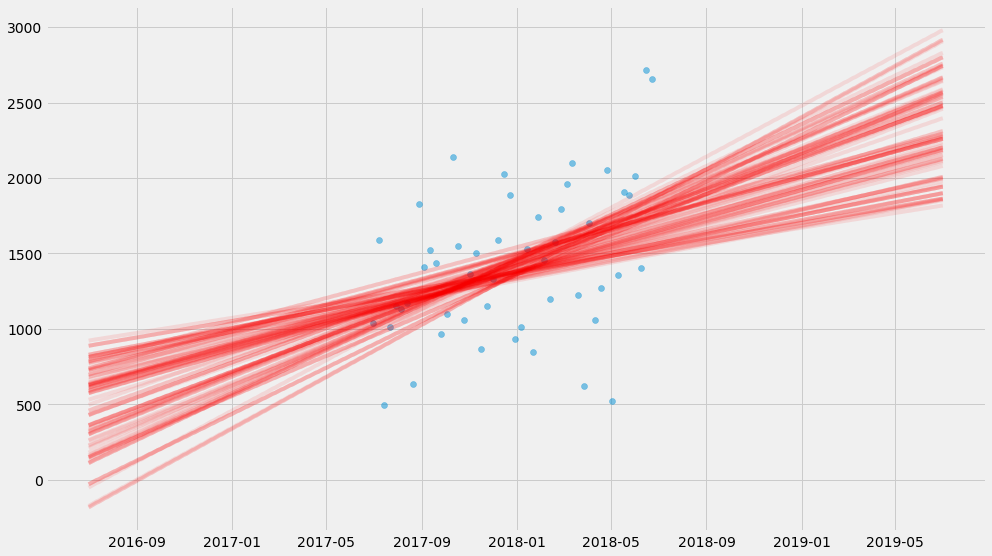

In [42]:
# Grab the last 10 from each walker
samples = sampler.chain[:, -10:, :].reshape((-1, ndim))

pyplot.scatter(ts, ys, alpha=0.5)
for k, m, log_sigma in samples:
    pyplot.plot(t_scale, model(x_scale, k, m), alpha=0.1, color='red')

There's a bit more stuff that goes into these methods – the sampling is a bit finicky and requires a bit of handholding to get to work well. I don't want to get into all the specifics, and I'm a layman myself. But it can often be several orders of magnitude faster than booststrapping.

As a side note, we end up with samples from the posterior distribution of $k, m, \sigma$. We can look at the probability distribution of these unknowns:

/Users/erikbern/uncertainty/env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


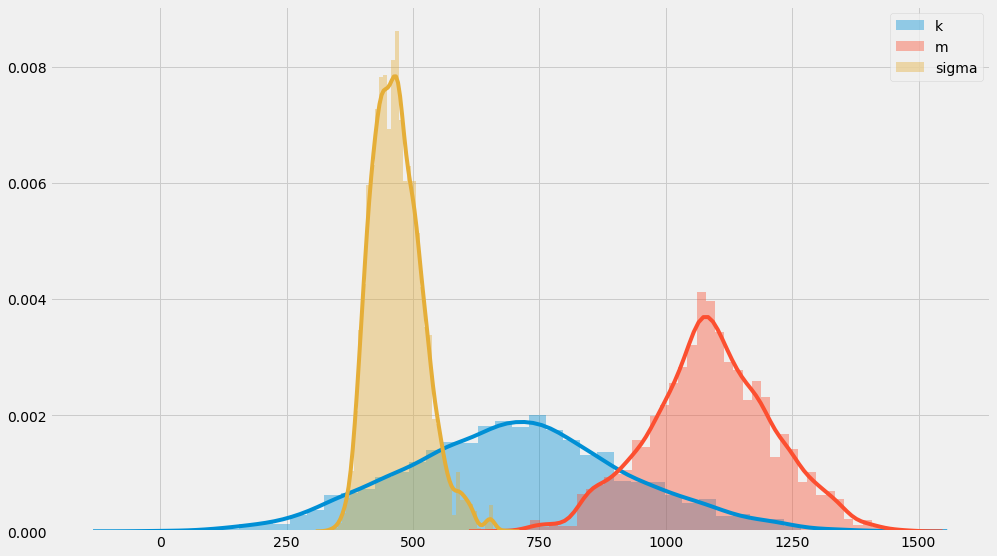

In [43]:
# Grab slightly more samples this time
samples = sampler.chain[:, -500:, :].reshape((-1, ndim))
k_samples, m_samples, log_sigma_samples = samples.T
seaborn.distplot(k_samples, label='k')
seaborn.distplot(m_samples, label='m')
seaborn.distplot(numpy.exp(log_sigma_samples), label='sigma')
pyplot.legend()

You can see that these distribution sort of center around $k=700$, $m=1000$, and $\sigma=500$ which is how we constructed them in the first place. That's somewhat reassuring!

Finally, we can plot the full uncertainty of predictions using the same methodology as for boostraps:

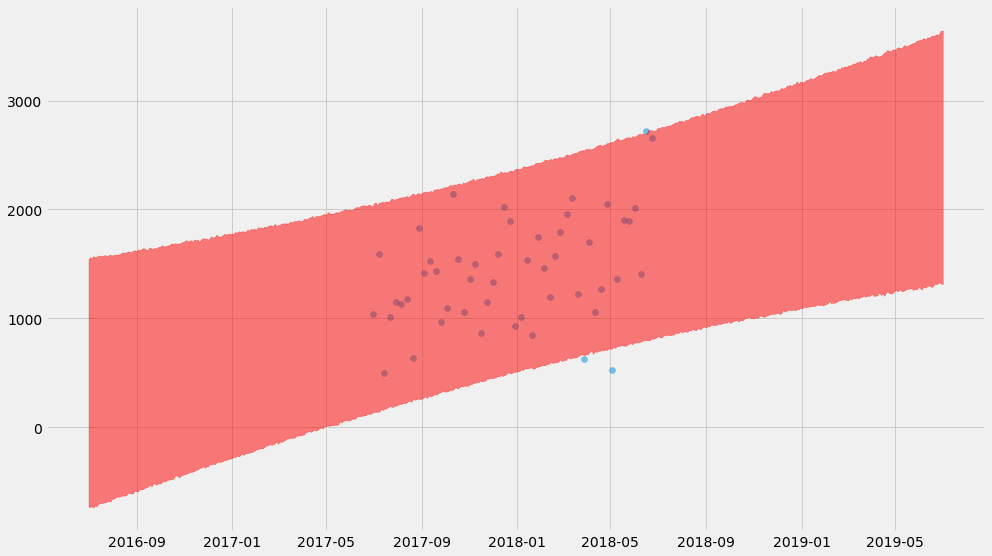

In [45]:
pyplot.scatter(ts, ys, alpha=0.5)
samples = sampler.chain[:, -4000:, :].reshape((-1, ndim))
curves = []
for k, m, log_sigma in samples:
    curves.append(
        model(x_scale, k, m) +
        numpy.exp(log_sigma) * numpy.random.normal(size=x_scale.shape)
    )

# Plot 95% confidence interval
lo, hi = numpy.percentile(curves, (2.5, 97.5), axis=0)
pyplot.fill_between(t_scale, lo, hi, color='red', alpha=0.5)

These Bayesian methods don't end here. In particular there's several libraries that work with these kind of problems. It turns out that if you express the problem in a more structured way (not just a negative log-likelihood function), you can make the sampling scale to large problems (as in, thousands of unknown parameters). For Python there's [PyMC3](https://docs.pymc.io/) and [PyStan](http://pystan.readthedocs.io/en/latest/), as well as the slightly more experimental (?) [Edward](http://edwardlib.org/) and [Pyro](http://pyro.ai/).